## Heart disease patients clasterization
Tymoteusz Urban, Karolina Mączka

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Data exploration

In [2]:
df = pd.read_csv('heart_disease_patients.csv')
df.drop('id', axis=1, inplace=True)
raw_data = df
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope
0   63    1   1       145   233    1        2      150      0      2.3      3
1   67    1   4       160   286    0        2      108      1      1.5      2
2   67    1   4       120   229    0        2      129      1      2.6      2
3   37    1   3       130   250    0        0      187      0      3.5      3
4   41    0   2       130   204    0        2      172      0      1.4      1


1. age - age in years
2. sex - sex (1 = male; 0 = female)
3. cp - chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
5. chol - serum cholestoral in mg/dl
6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
7. restecg - resting electrocardiographic results (0 = normal; 1 = having ST-T; 2 = hypertrophy)
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest
11. slope - the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        303 non-null    int64  
 1   age       303 non-null    int64  
 2   sex       303 non-null    int64  
 3   cp        303 non-null    int64  
 4   trestbps  303 non-null    int64  
 5   chol      303 non-null    int64  
 6   fbs       303 non-null    int64  
 7   restecg   303 non-null    int64  
 8   thalach   303 non-null    int64  
 9   exang     303 non-null    int64  
 10  oldpeak   303 non-null    float64
 11  slope     303 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 28.5 KB


In [5]:
df.isnull().sum()

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64

There are no null values, all variables are clean and properly encoded

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trestbps'}>,
        <Axes: title={'center': 'chol'}>],
       [<Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalach'}>],
       [<Axes: title={'center': 'exang'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

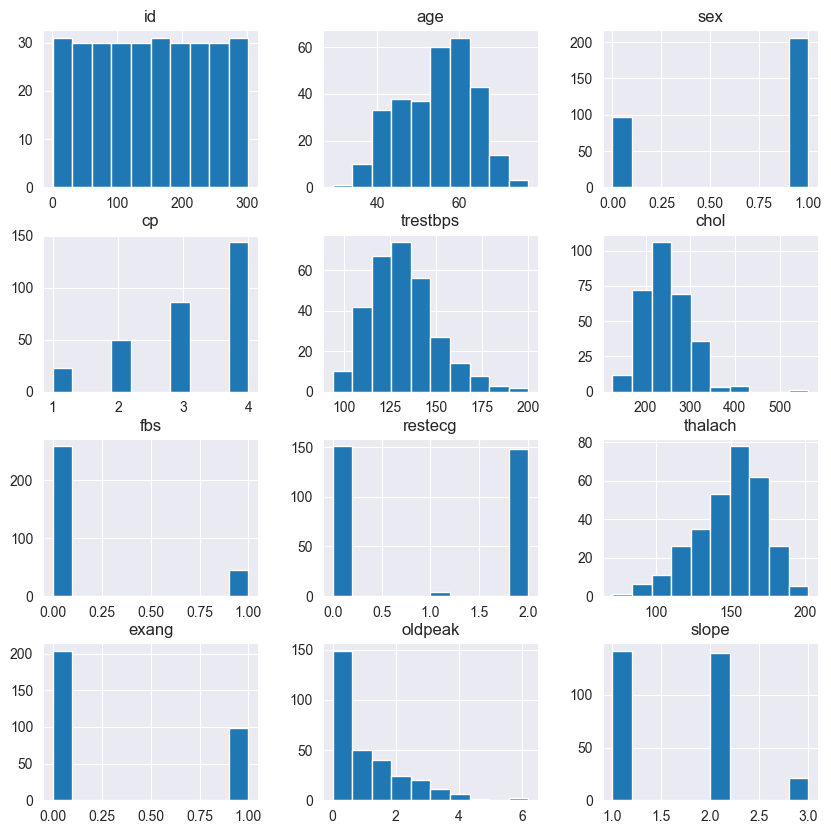

In [6]:
df.hist(figsize=(10,10))

<Axes: >

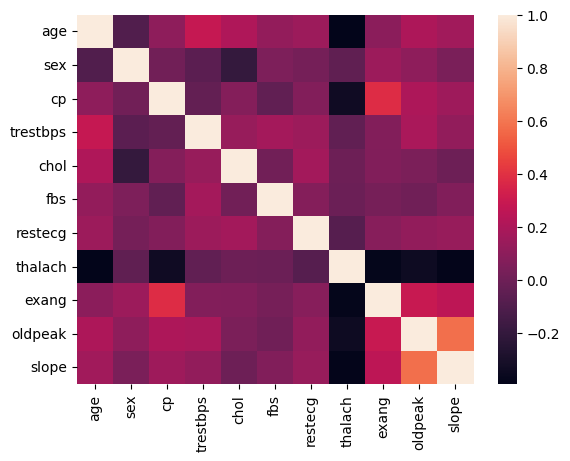

In [14]:
sns.heatmap(df.corr())

There is quite high correlation between oldpeak and slope and also between cp and exang, but is it big enough to delete any of the columns?

In [8]:
print(f"oldpeak and slope correlation: {df[['oldpeak', 'slope']].corr().iloc[0,1]}")
print(f"cp and exang correlation: {df[['cp', 'exang']].corr().iloc[0,1]}")

oldpeak and slope correlation: 0.5775368167291409
cp and exang correlation: 0.38405952636486906


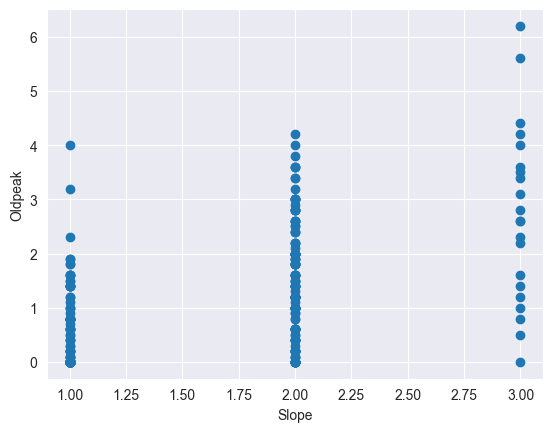

In [12]:
plt.scatter(df['slope'], df['oldpeak'])
plt.xlabel('Slope')
plt.ylabel('Oldpeak')
plt.show()

In [37]:
# Another approach
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

In [38]:
calc_vif(df)

,variables,VIF
0,age,40.471744
1,sex,3.231010
2,cp,13.035948
3,trestbps,64.649980
4,chol,30.072029
5,fbs,1.217729
6,restecg,2.119624
7,thalach,34.695005
8,exang,2.027199
9,oldpeak,2.988769


Which variables should we drop? According to traditional correlation between variables it could be slope, but after calculatin VIF it seems that age, trestbps, chol and thalach are highly correlated with the other variables.

## Preprocessing

In [10]:
# Outliers removal - replace lower_bound and upper_bound, only numeric columns
def replace_outliers(data, k=1.5):
    """
    Removes outliers from a pandas DataFrame using the interquartile range (IQR) method.

    :param data: dataframe
    :param k: A multiplier to adjust the outlier threshold. By default, k is set to 1.5.
    :return: dataframe
    """
    for col in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']:
        q1, q3 = np.percentile(data[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        mask = (data[col] < lower_bound)
        data.loc[mask, col] = lower_bound
        mask = (data[col] > upper_bound)
        data.loc[mask, col] = upper_bound
    return data

In [11]:
replace_outliers(df)

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,1,63.0,1,1,145,233,1,2,150.0,0,2.3,3
1,2,67.0,1,4,160,286,0,2,108.0,1,1.5,2
2,3,67.0,1,4,120,229,0,2,129.0,1,2.6,2
3,4,37.0,1,3,130,250,0,0,187.0,0,3.5,3
4,5,41.0,0,2,130,204,0,2,172.0,0,1.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
298,299,45.0,1,1,110,264,0,0,132.0,0,1.2,2
299,300,68.0,1,4,144,193,1,0,141.0,0,3.4,2
300,301,57.0,1,4,130,131,0,0,115.0,1,1.2,2
301,302,57.0,0,2,130,236,0,2,174.0,0,0.0,2


In [6]:
# Instead manual deletion of variables we could use PCA for reducing dimensionality
def remove_overshadowing(data):
    """
    Performs Principal Component Analysis (PCA) on a given dataset.

    :param data: dataframe
    :return:
            A reduced version of the input DataFrame, containing the first n principal components
            where n is the smallest number of components that explain at least 95% of the variance in the data.
            The columns of the new DataFrame are named "PC1", "PC2", etc.

    """
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(data)

    # Determine the number of principal components to retain
    explained_variances = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variances)
    n_components = np.argmax(cumulative_variances > 0.95) + 1

    # Retain the first n principal components
    X_reduced = X_pca[:, :n_components]

    # Convert back to a pandas DataFrame
    df_reduced = pd.DataFrame(X_reduced, columns=["PC"+str(i) for i in range(1, n_components+1)])
    
    return df_reduced

We will also need to scale our data - we can try 3 different ways to do it. We will test it later.

In [13]:
def standarize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    return X


def normalize(X):
    normalizer = Normalizer()
    X_normalized = normalizer.fit_transform(X)
    X = pd.DataFrame(X_normalized, columns=X.columns)
    return X


def minmax(X):
    minmaxer = MinMaxScaler()
    X_scaled = minmaxer.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    return X

## Number of clusters

In [3]:
# We will use functions from other python files, so we don't have to run whole notebook every time
from preprocessing import standarize, minmax, normalize, replace_outliers, preprocessing
from KMeans import k_means_alg

First we prepare methods for finding optimal number of clusters

In [9]:
def num_of_clus_elbow(data) -> int:
    """
        Finds optimal number of clusters using elbow method.

        :param data: dataframe
        :return: number of clusters
    """
    sum_of_squared_distances = []
    K = range(1, 10)
    for num_clusters in K:
        kmeans = KMeans(n_clusters=num_clusters, n_init=10)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)

    # finding elbow point
    sd = np.diff(sum_of_squared_distances, 2)
    elbow_point = np.argmax(sd) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 10), sum_of_squared_distances, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    return elbow_point

In [10]:
def num_of_clus_silhouette(data) -> int:
    """
    Finds optimal number of clusters using silhouette method.

    :param data: dataframe
    :return: number of clusters
    """
    silhouette_scores = []
    for i in range(2, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)

    silhouette_point = np.argmax(silhouette_scores) + 2

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.show()

    return silhouette_point

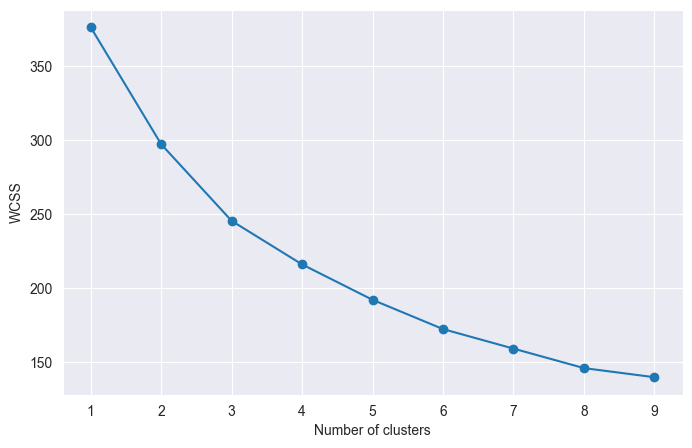

Elbow method: 2


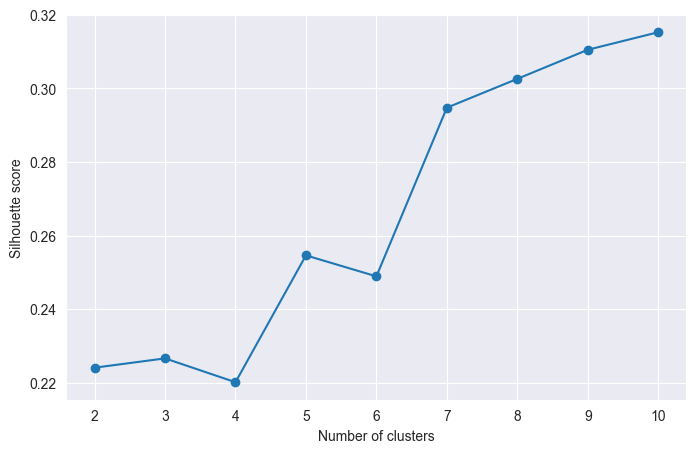

Silhouette method: 10


In [15]:
# Let's check elbow method
df_clusters = replace_outliers(raw_data)
df_clusters = minmax(df_clusters)
print('Elbow method:', num_of_clus_elbow(df_clusters))
print('Silhouette method:', num_of_clus_silhouette(df_clusters))

We can see that returned values are different. Now we can test it on a baseline model:

In [16]:
for i in [2,10]:
    y_kmeans = k_means_alg(df_clusters, num_clusters=i)
    print(f"silhouette score: {silhouette_score(df_clusters, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_clusters, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_clusters, y_kmeans)}")

number of clusters: 2
silhouette score: 0.2241375053087164
calinski harabasz score: 79.98550665115155
davies bouldin score: 1.7703026238946138
number of clusters: 10
silhouette score: 0.31528919893487084
calinski harabasz score: 59.14748434187917
davies bouldin score: 1.2604539559168702


Results vary depending on the score used, but overall results are better for 10 clusters. On the other hand, 10 clusters is too much, and we can try using something between for example 5. Now let's check how preprocessing influences clusters and score.

In [34]:
processing = ['stand', 'minmax', 'norm']
for proc in processing:
    print(f'Processing: {proc}')
    df_proc = preprocessing(raw_data, rem_over=False, process=proc)
    y = k_means_alg(df_proc, num_clusters=5)
    print(f"silhouette score: {silhouette_score(df_proc, y)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_proc, y)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_proc, y)}")

Processing: stand
number of clusters: 5
silhouette score: 0.13607627603761924
calinski harabasz score: 38.93709452833012
davies bouldin score: 1.9603184323002545
Processing: minmax
number of clusters: 5
silhouette score: 0.2546564950044768
calinski harabasz score: 71.37014463635018
davies bouldin score: 1.473018971910774
Processing: norm
number of clusters: 5
silhouette score: 0.30478025913859985
calinski harabasz score: 192.93541615870168
davies bouldin score: 1.0068504130263771


We can see that number of clusters vary. Normalizer has the best results, but we can see that normalized data is hard to interpret:

In [44]:
normalize(raw_data).head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,0.197450,0.003134,0.003134,0.454449,0.730252,0.003134,0.006268,0.470119,0.000000,0.007208,0.009402
1,0.190592,0.002845,0.011379,0.455146,0.813573,0.000000,0.005689,0.307224,0.002845,0.004267,0.005689
2,0.225852,0.003371,0.013484,0.404511,0.771942,0.000000,0.006742,0.434850,0.003371,0.008764,0.006742
3,0.108744,0.002939,0.008817,0.382073,0.734756,0.000000,0.000000,0.549598,0.000000,0.010287,0.008817
4,0.136825,0.000000,0.006674,0.433835,0.680787,0.000000,0.006674,0.573997,0.000000,0.004672,0.003337


For example values in sex column are around 0.003 while in chol ot thalach values are way bigger. Thus, minmax scaler is the most reasonable scaler, but even 5 clusters is quite a lot. Let's check it with some other numbers of clusters taken from elbow and silhouette plots:

In [36]:
for i in [2, 3, 4, 5, 10]:
    df_minmax = preprocessing(raw_data, rem_over=False, process='minmax')
    y_kmeans = k_means_alg(df_minmax, num_clusters=i)
    print(f"silhouette score: {silhouette_score(df_minmax, y_kmeans)}")
    print(f"calinski harabasz score: {calinski_harabasz_score(df_minmax, y_kmeans)}")
    print(f"davies bouldin score: {davies_bouldin_score(df_minmax, y_kmeans)}")
    print(f"davies bouldin score: {y_kmeans.score}")

number of clusters: 2
silhouette score: 0.2241375053087164
calinski harabasz score: 79.98550665115155
davies bouldin score: 1.7703026238946138
number of clusters: 3
silhouette score: 0.2266676350179122
calinski harabasz score: 79.86734271351
davies bouldin score: 1.637272907474377
number of clusters: 4
silhouette score: 0.2201901015673123
calinski harabasz score: 73.85623075801712
davies bouldin score: 1.4030802065113115
number of clusters: 5
silhouette score: 0.2546564950044768
calinski harabasz score: 71.37014463635018
davies bouldin score: 1.473018971910774
number of clusters: 10
silhouette score: 0.31528919893487084
calinski harabasz score: 59.14748434187917
davies bouldin score: 1.2604539559168702


On average the more clusters the better the results, but we have to draw a line somewhere and pick apropriate number of clusters. Last question is if we should use PCA for reducing dimensionality.

In [24]:
df_pca = preprocessing(raw_data, process='minmax')
y_kmeans = k_means_alg(df_pca, num_clusters=3)
print(f"silhouette score: {silhouette_score(df_pca, y_kmeans)}")
print(f"calinski harabasz score: {calinski_harabasz_score(df_pca, y_kmeans)}")
print(f"davies bouldin score: {davies_bouldin_score(df_pca, y_kmeans)}")

number of clusters: 3
silhouette score: 0.24463317143265548
calinski harabasz score: 104.10959308674269
davies bouldin score: 1.326866652930111


Some scores have improved a little bit, and it is easier to visualize clustering as we only have 3 variables, but we lose interpretability which is crucial in medical data analysis. That said in preprocessing we will stick to minmax scaler and outliers removal, and we will be using 3 clusters.

## Algorithms

In [5]:
from KMeans import mean_inclust_dist, std_dev_of_inclust_dist

In [18]:
df_scores = preprocessing(raw_data, rem_over=False, process='minmax')
y_scores = k_means_alg(df_scores, num_clusters=3)
print(mean_inclust_dist(df_scores, y_scores))
print(std_dev_of_inclust_dist(df_scores, y_scores))

number of clusters: 3
1.225302365784205
0.07406982949090163


In [9]:
# To be continued ...